I'll use this to calculate and plot the survival probability for the distance and energy ranges relevant for geonu's. Using this formula:

(this is from https://www.hindawi.com/journals/ahep/2012/235686/ -- it is eq. 4.3, where $\Delta_{21}$ is written explicitly using eq. 4.2):

$$P_{ee}(E_{\nu}, |\overrightarrow{r}-\overrightarrow{r'}|) = 1 - (\cos^4 \theta_{13} \sin^2 2\theta_{12} \sin^2 ( \frac{1.27 \delta m_{21}^2 |\overrightarrow{r}-\overrightarrow{r'}|}{E_{\nu}}) + \frac{1}{2}\sin^2 2\theta_{13})$$

For the 1.27 factor to be true, $\delta m_{21}^2$ should be expressed in eV, $E_{\nu}$ in MeV and $|\overrightarrow{r}-\overrightarrow{r'}|$ in m, so we will have to use 1.27/1000 instead to express distance in km.

The position $\overrightarrow{r}$ can be hardcoded, it is the position of the SNO+ detector. Now that we're just looking at spherical shells, it doesn't matter where we put it, so set $x = y = 0$ and $z = R_{Earth} - 2 = 6369 km$.

The relevant energy range is $1.8 - 3.3 $ MeV (because 1.8 is the IBD detection threshold, and 3.3 is the maximum geonu energy for which significant enough fluxes are emitted). The distance varies between 0 km and 6370 ish km.

Create a function that outputs an array P_ee (where again, the index identifies the value) for a certain energy, $\Delta m_{21}^2$ and $\theta_{12}$. This will take as inputs an array of energy values (the middle points of the bins we will use to plot the expected detected counts), and one value for each of the oscillation parameters

The value of $\theta_{13}$ will also be fixed . The last paper measuring $\theta_{13}$ seems to be https://inspirehep.net/literature/2601288, and they measured $\sin^2 2\theta_{13} = 0.0851 ± 0.0024$ so we'll use that (without uncertainties). From https://pdgprod.lbl.gov/pdgprod/pdgLive/DataBlock.action?node=S067P13 conversion of DAYA BAY result to  $\sin^2 \theta_{13} = 0.0217$, so $\cos^2 \theta_{13} = 1 - 0.0217 = 0.9783 \implies \cos^4 \theta_{13} = 0.9571$.

Want to implement a function with these properties based on the formula above:

    Inputs: array of energies, array of points (each entry contains Cartersian coordinates for that point), theta_12, delta_m_21_squared
    Outputs: array of P_ee values, one for each combination of position and energy
    
I will format the output such that the first row are the survival probabilities corresponding to $E_1$, the first column are the survival probabilities corresponding to the first point in the array of points etc. So:

$$ P_{ee} = \begin{bmatrix}
P_{ee}(E_1, p_1) & P_{ee}(E_1, p_2) & P_{ee}(E_1, p_3) & ...\\
P_{ee}(E_2, p_1) & P_{ee}(E_2, p_2) & P_{ee}(E_2, p_3) & ...\\
...
\end{bmatrix}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def P_ee(points_array, energy_array, theta_12, delta_m_21_squared):
    
    P_ee = np.zeros((len(energy_array), len(points_array)))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
        
    #want positions relative to sno+
    
    relative_distance_array = calc_relative_dist(points_array)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            P_ee[i][j] = 1 - (cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * relative_distance_array[j] )/(energy_array[i]/1000)))**2 + (1/2) * sin_2_theta_13_squared)
            
    return P_ee

In [3]:
def P_ee_simplified(distance_array, energy_array, theta_12, delta_m_21_squared):
    
    P_ee = np.zeros((len(energy_array), len(distance_array)))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
    for i in range(len(energy_array)):
        for j in range(len(distance_array)):
            P_ee[i][j] = 1 - (cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * distance_array[j] )/(energy_array[i]/1000)))**2 + (1/2) * sin_2_theta_13_squared)
            
    return P_ee

Try these for now:



In [4]:
theta_12 = 1.04134
delta_m_21_squared = 7.53 * 10**(-5)

In [5]:
distance_array = np.linspace(0, 6400, 1000)
energy_array = np.linspace(1.8, 3.3, 100)

In [6]:
P_ee_matrix = P_ee_simplified(distance_array, energy_array, theta_12, delta_m_21_squared)


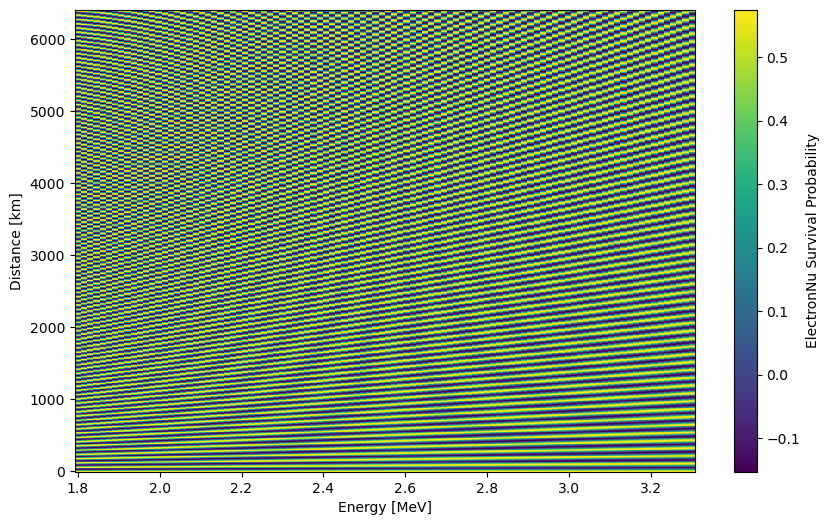

In [7]:
E, L = np.meshgrid(energy_array, distance_array)  # Create a grid of E and L values


# Create a color map plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(E, L, P_ee_matrix.T, cmap='viridis')  # Transpose your_matrix to match dimensions

# Add labels and a colorbar
plt.xlabel('Energy [MeV]')
plt.ylabel('Distance [km]')
plt.colorbar(label='ElectronNu Survival Probability')

# Show the plot
plt.show()

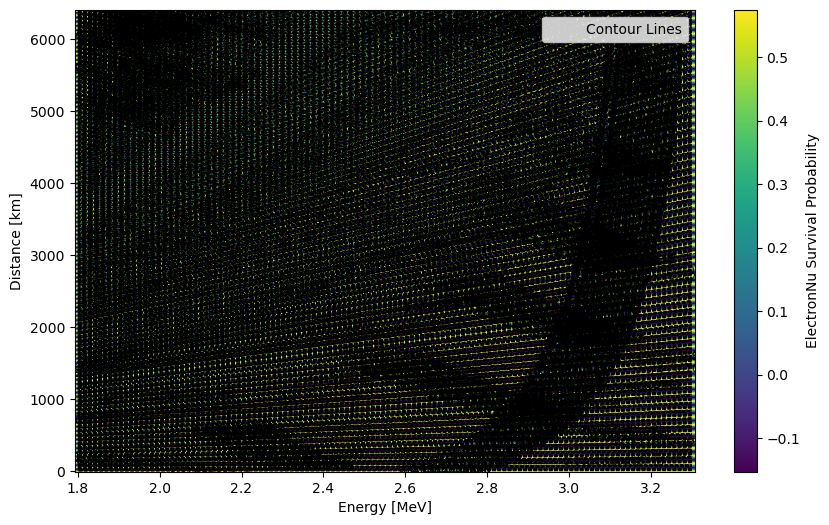

In [8]:
E, L = np.meshgrid(energy_array, distance_array)  # Create a grid of E and L values

# Create a color map plot with contour lines
plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(E, L, P_ee_matrix.T, cmap='viridis')  # Transpose P_ee_matrix to match dimensions

# Add contour lines
contour_levels = np.linspace(np.min(P_ee_matrix), np.max(P_ee_matrix), 10)
contour = plt.contour(E, L, P_ee_matrix.T, levels=contour_levels, colors='black', linestyles='dashed', linewidths=0.7)

# Label the contour lines with values up to 10 significant figures
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.10f')

# Add labels, a colorbar, and legend
plt.xlabel('Energy [MeV]')
plt.ylabel('Distance [km]')
plt.colorbar(pcm, label='ElectronNu Survival Probability')
plt.legend([contour.collections[0]], ['Contour Lines'])

# Show the plot
plt.show()

CONCLUSIONS:


1) Over the energy and distance ranges for detectable geoneutrinos, the survival probability is the same up to the first 9 digits, so it's definitely ok to treat as constant unless we're fitting for the oscillation parameters
2) The value of that constant should be $P_{ee} = 0.5744999$

The reason why these are so similar is because the $\frac{1}{2}\sin^2 2\theta_{13}$ term dominates in the $P_{ee}$ formula; We used $1 -\frac{1}{2}\sin^2 2\theta_{13} = 1 - \frac{0.851}{2} = 0.5745$, while the other term is very very small; if we calculate the other term separately and make a plot:

In [9]:
def P_ee_small_term(distance_array, energy_array, theta_12, delta_m_21_squared):
    
    P_ee_small_term = np.zeros((len(energy_array), len(distance_array)))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
    for i in range(len(energy_array)):
        for j in range(len(distance_array)):
            P_ee_small_term[i][j] = cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * distance_array[j] )/(energy_array[i]/1000)))**2
            
    return P_ee_small_term

In [10]:
small_term_matrix = P_ee_small_term(distance_array, energy_array, theta_12, delta_m_21_squared)

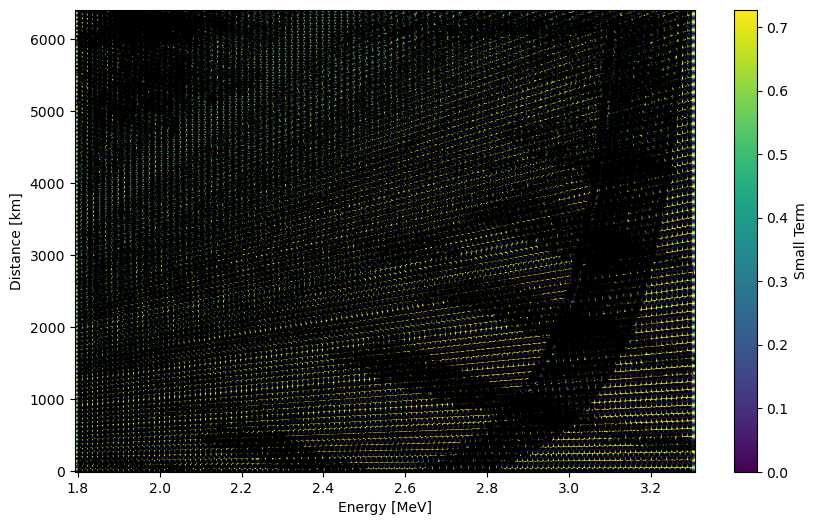

In [11]:
# Create a color map plot with contour lines
plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(E, L, small_term_matrix.T, cmap='viridis')  # Transpose P_ee_matrix to match dimensions

# Add contour lines
contour_levels = np.linspace(np.min(small_term_matrix), np.max(small_term_matrix), 10)
contour = plt.contour(E, L, small_term_matrix.T, levels=contour_levels, colors='black', linestyles='dashed', linewidths=0.7)

# Label the contour lines with values up to 10 significant figures
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.10f')

# Add labels, a colorbar, and legend
plt.xlabel('Energy [MeV]')
plt.ylabel('Distance [km]')
plt.colorbar(pcm, label='Small Term')

# Show the plot
plt.show()

Now try different values of the oscillation parameters to see how this small term changes; for it to make a difference, we would like to make it as big as possible. So, if the formula for the small term is:

$$\cos^4 \theta_{13} \sin^2 2\theta_{12} \sin^2 ( \frac{1.27 \delta m_{21}^2 |\overrightarrow{r}-\overrightarrow{r'}|}{1000 E_{\nu}})$$ 

   LATER UPDATE: THIS IS WRONG, THE 1000 IS ON TOP

We want this to be as big as possible, so set $\sin ^2 2 \theta_{12} = 1$. The other sin will be very very small because $\delta m_{21}^2$ is of order $10^{-5}$. As a maximum limit, set it equal to $10^{-3}$ -- this is already very unreasonable, but let's see what we get:



In [14]:
def P_ee_big_small_term(distance_array, energy_array, theta_12, delta_m_21_squared):
    
    P_ee_small_term = np.zeros((len(energy_array), len(distance_array)))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
    for i in range(len(energy_array)):
        for j in range(len(distance_array)):
            P_ee_small_term[i][j] = cos_theta_13_fourth  * (np.sin((1.27 * delta_m_21_squared * distance_array[j] )/(1000 * energy_array[i])))**2
            
    return P_ee_small_term

In [15]:
big_small_term_matrix = P_ee_small_term(distance_array, energy_array, theta_12, 10**(-3))

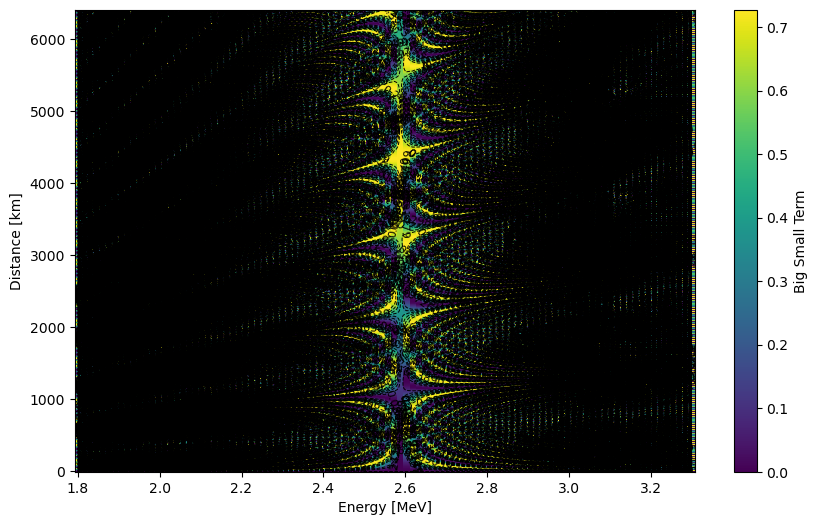

In [16]:
# Create a color map plot with contour lines
plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(E, L, big_small_term_matrix.T, cmap='viridis')  # Transpose P_ee_matrix to match dimensions

# Add contour lines
contour_levels = np.linspace(np.min(big_small_term_matrix), np.max(big_small_term_matrix), 10)
contour = plt.contour(E, L, big_small_term_matrix.T, levels=contour_levels, colors='black', linestyles='dashed', linewidths=0.7)

# Label the contour lines with values up to 10 significant figures
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.10f')

# Add labels, a colorbar, and legend
plt.xlabel('Energy [MeV]')
plt.ylabel('Distance [km]')
plt.colorbar(pcm, label='Big Small Term')

# Show the plot
plt.show()

These are bigger, but still very small - I doubt that this compares with any other errors that are taken into account. There is still something that is not clear to me though: this should also be true for reactor neutrinos! The energy might be even bigger for them, so this term is even smaller; the allowed distance range is the same because all reactors are on Earth (shocking, I know). So how can we get any estimate of the parameters if oscillations contribute so little to the total flux? Something must be wrong ... Oscillations contribute, but just as a scaling factor??

To figure out what I did wrong, I'll plot in 2D as a function of $L/E$ instead. To pick the range:

In [17]:
def L_E_ratio(distance_array, energy_array):
    ratio = np.zeros((len(energy_array), len(distance_array)))
    
    for i in range(len(energy_array)):
        for j in range(len(distance_array)):
            ratio[i][j] = distance_array[j]/energy_array[i]
            
    return ratio

In [18]:
ratio = L_E_ratio(distance_array, energy_array)

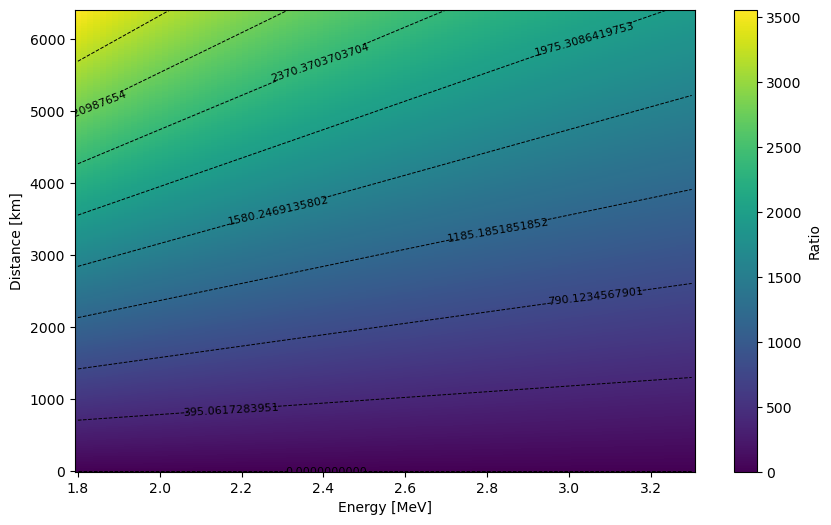

In [19]:
# Create a color map plot with contour lines
plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(E, L, ratio.T, cmap='viridis')  # Transpose P_ee_matrix to match dimensions

# Add contour lines
contour_levels = np.linspace(np.min(ratio), np.max(ratio), 10)
contour = plt.contour(E, L, ratio.T, levels=contour_levels, colors='black', linestyles='dashed', linewidths=0.7)

# Label the contour lines with values up to 10 significant figures
plt.clabel(contour, inline=True, fontsize=8, fmt='%1.10f')

# Add labels, a colorbar, and legend
plt.xlabel('Energy [MeV]')
plt.ylabel('Distance [km]')
plt.colorbar(pcm, label='Ratio')

# Show the plot
plt.show()


Plotting was a bit silly to be fair, I just want the min and max.

In [20]:
min_ratio = np.min(ratio)
print("min ratio is "+str(min_ratio))
max_ratio = np.max(ratio)
print("max ratio is "+str(max_ratio))

min ratio is 0.0
max ratio is 3555.5555555555557


In [21]:
L_E_ratio_array = np.linspace(0, 3600, 1000)

In [24]:
def P_ee_vs_ratio(ratio_array, theta_12, delta_m_21_squared):
    
    P_ee = np.zeros(len(ratio_array))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
    for i in range(len(ratio_array)):
        P_ee[i] = 1 - (cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * ratio_array[i] )/(1000)))**2 + (1/2) * sin_2_theta_13_squared)
            
    return P_ee

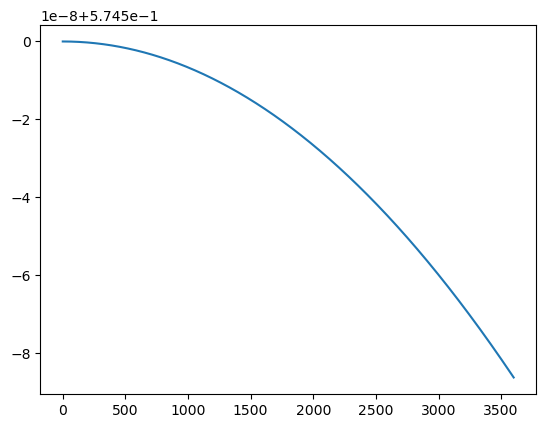

In [25]:
P_ee_vs_ratio = P_ee_vs_ratio(L_E_ratio_array, theta_12, delta_m_21_squared)

plt.plot(L_E_ratio_array, P_ee_vs_ratio)
plt.show()

I don't like this, because this plot is supposed to look like this:

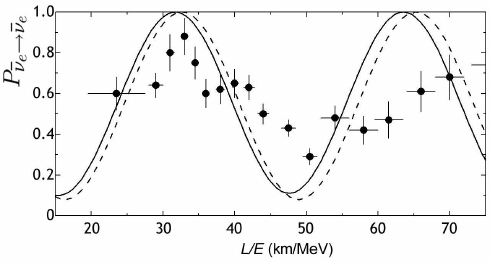

(from https://www.researchgate.net/figure/Reactor-antineutrino-survival-probabilities-as-a-function-of-L-E-in-the-puma-model-solid_fig4_51930147)

This might be an issue with that 1/1000 factor, I need to check when I'm not extremely tired. Try plotting the same thing if we adjust the formula so the 1/1000 factor is not there

In [28]:
def P_ee_vs_ratio_adjusted(ratio_array, theta_12, delta_m_21_squared):
    
    P_ee = np.zeros(len(ratio_array))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
    for i in range(len(ratio_array)):
        P_ee[i] = 1 - (cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * ratio_array[i] )/(1/1000)))**2 + (1/2) * sin_2_theta_13_squared)
            
    return P_ee

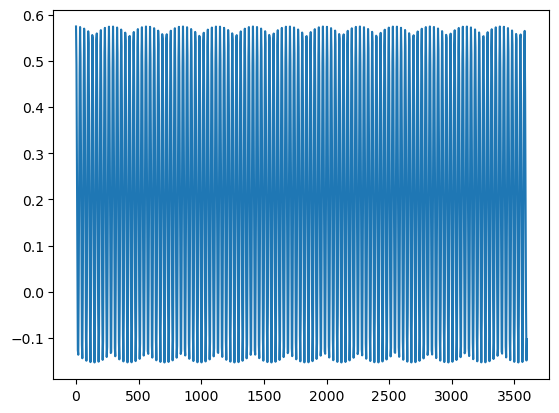

In [29]:
P_ee_vs_ratio = P_ee_vs_ratio_adjusted(L_E_ratio_array, theta_12, delta_m_21_squared)

plt.plot(L_E_ratio_array, P_ee_vs_ratio)
plt.show()

why?? what is wrong???

In [33]:
print(P_ee_vs_ratio[0])
print(L_E_ratio_array[0])

0.5745
0.0


From the same source as the plot above:

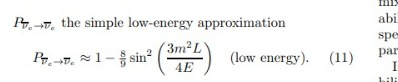

In [47]:
def P_ee_vs_ratio_adjusted_2(ratio_array, delta_m_21_squared):
    
    P_ee = np.zeros(len(ratio_array))
    
    for i in range(len(ratio_array)):
        P_ee[i] = 1 - (8/9)*(np.sin((3 * delta_m_21_squared * ratio_array[i])/(4)))**2
    return P_ee

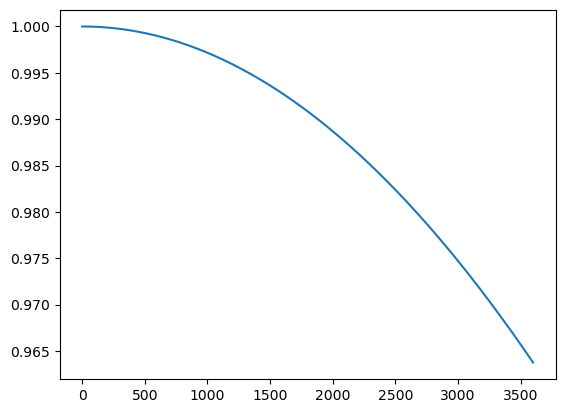

In [48]:
P_ee_vs_ratio = P_ee_vs_ratio_adjusted_2(L_E_ratio_array, delta_m_21_squared)

plt.plot(L_E_ratio_array, P_ee_vs_ratio)
plt.show()

This is still wrong for most of the range, I guess the ratio really needs to be small for this to hold

Should redo the calculation using the full three-flavour survival probability formula: 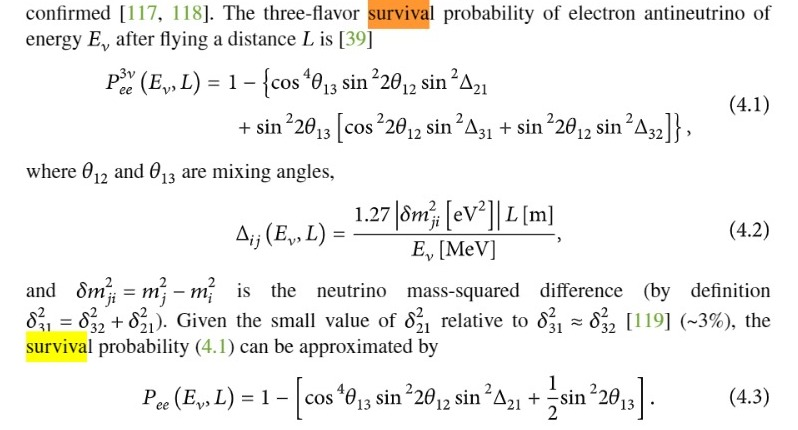

(from https://www.hindawi.com/journals/ahep/2012/235686/ again)

I'm pretty sure that my implementation of the second formula is correct, so I'm pretty sure this formula must be wrong. At zero distance, the survival probability should be 1, and it's not if we use this approximation: the factor that depends on $\Delta $ must be 0 because $\Delta$ is 0, and we're left with non-zero stuff!

When I implement this, I must keep in mind that the $\Delta$'s must be adjusted down by a factor of 1000 so we can express distance in km. Or up? Waaait...

In [60]:
def P_ee_vs_ratio_adjusted_3(ratio_array, theta_12, delta_m_21_squared):
    
    P_ee = np.zeros(len(ratio_array))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
    for i in range(len(ratio_array)):
        P_ee[i] = 1 - (cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * ratio_array[i])/(1000)))**2 + (1/2) * sin_2_theta_13_squared)
            
    return P_ee

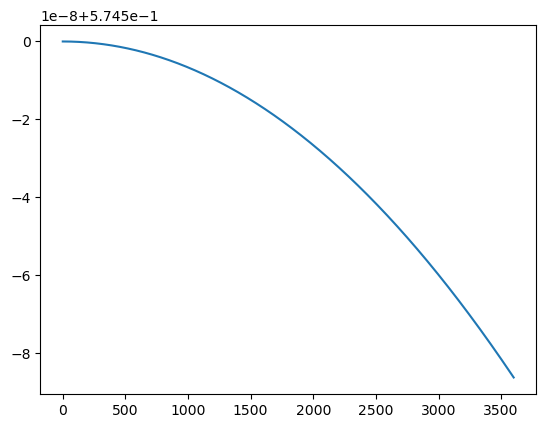

In [61]:
P_ee_vs_ratio = P_ee_vs_ratio_adjusted_3(L_E_ratio_array, theta_12, delta_m_21_squared)

plt.plot(L_E_ratio_array, P_ee_vs_ratio)
plt.show()

Ok yeah, still fucked

I told chatGPT to write my formula (the one I used in the last definition of the function) as a LaTeX equation and it gave me this:

$$1 - \left(\cos^4(\theta_{13}) \cdot \left(\sin(2 \theta_{12})\right)^2 \cdot \left(\sin\left(\frac{1.27 \cdot \Delta m_{21}^2 \cdot \text{{ratio_array}}[i]}{1000}\right)\right)^2 + \frac{1}{2} \sin^2(2 \theta_{13})\right)$$

It definitely looks the same, but how the fuck does it end up being negative?

In [62]:
print(P_ee_vs_ratio[0])

0.5745
